# CM0868 PARCIAL 1 - Parte Práctica
Esta parte práctica del primer parcial consta de dos partes:

1.   Descomponer el error de generalización,
2.   Entender los regularizadores para ajustar la complejidad del modelo.

Cada sección es auto-contenida, por lo que es preferible que importe lo que se necesite en cada una (para la muestra importo numpy en ambas partes).



## (40%) Error de generalización

La descomposición del error de generalización (ver **7.3** de *Elements of Statistical Learning*) en `ruido`, `varianza` y `sesgo^2` nos ayuda a comprender en la práctica cuál estrategia seguir. Es claro que a pesar de ser un ejercicio teórico (con datos generados), podemos usar este aprendizaje para evaluar nuevos algoritmos que vayamos aprendiendo con este punto de vista presente.

A continuación vamos a importar dos modelos (cada uno con características diferentes), vamos a generar unos datos en los cuales conozcamos la verdadera función y descomponer los errores encontrados de la manera que aprendimos.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Configuración
n_repeat = 50       # Iteraciones para el esperado
n_train = 100       # Tamaño de entrenamiento
n_test = 1000       # Tamaño de pruebas
noise = 0.1         # Desviación estándar del ruido
np.random.seed(42)

# Para esta función una regresión lineal no es suficiente, entonces usaremos un pipeline para usar
# polinomios y luego regularizaremos (no es necesario que cambien el modelo)
poly = PolynomialFeatures(degree=9, include_bias=False)
model = Ridge()
poly_model = make_pipeline(poly, model)
# Vamos a explorar los errores de estimadores diferentes, uno con alta varianza (como KNN) y otro
# con alto sesgo (como regresión lineal)
estimators = [("KNeighbors", KNeighborsRegressor(n_neighbors=1)),
              ("PolyRegression", poly_model)]
n_estimators = len(estimators)

Generemos los datos a partir de una función conocida.

Muestras de entrenamiento = (50, 100)
Muestras de prueba = (1000, 50)



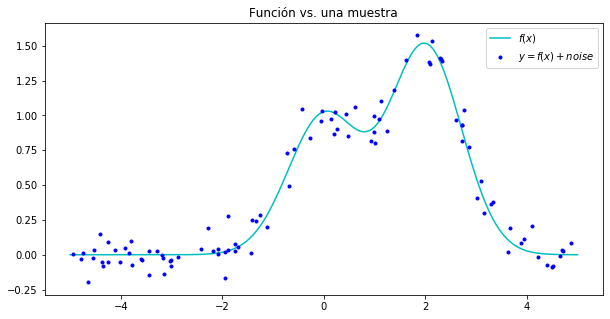

In [2]:
# Función a estimar
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

# Generador de muestras
def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)
    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train = []
y_train = []
for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)
# Imprimo los tamaños
print("Muestras de entrenamiento = (", len(y_train), ", ", len(y_train[0]), ")", sep="")
print("Muestras de prueba =", y_test.shape)
print()
# Grafico la función vs. los 'y' de pruebas
plt.figure(figsize=(10, 5))
plt.plot(X_test, f(X_test), "c", label="$f(x)$")
plt.plot(X_train[0], y_train[0], ".b", label="$y = f(x)+noise$")
plt.legend()
plt.title("Función vs. una muestra")
plt.show()

Tenemos entonces generadas varias muestras para entrenar (`n_repeat`), cada una de un tamaño dado (`n_train`). Usaremos estas muestras y nuestro conocimiento en la función original para estimar el error de generalización y sus componentes.

Complete el código con su conocimiento de la descomposición (sólo tres líneas de código) y en la celda más abajo escriba sus conclusiones (no más de dos párrafos).

KNeighbors: 0.0213 (error) = 0.0002 (bias^2)  + 0.0111 (var) + 0.0098 (noise)
PolyRegression: 0.0272 (error) = 0.0124 (bias^2)  + 0.0049 (var) + 0.0098 (noise)


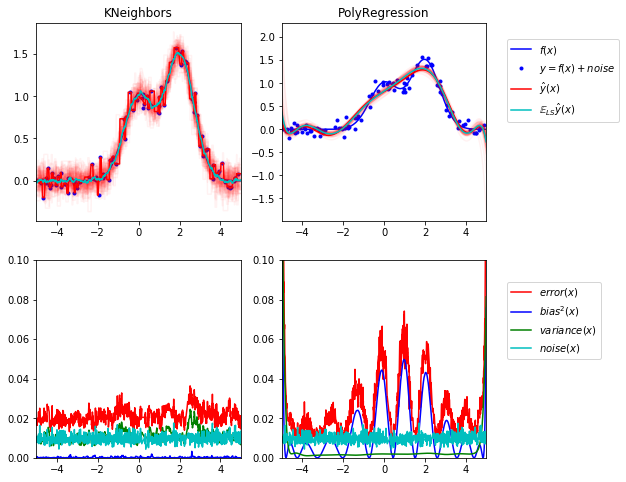

In [3]:
plt.figure(figsize=(10, 8))

# Iteramos sobre los diferentes estimadores (modelos)
for n, (name, estimator) in enumerate(estimators):
    # Predicciones
    y_pred = np.zeros((n_test, n_repeat))
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_pred[:, i] = estimator.predict(X_test)

    # Calculo el error de generalización para cada muestra entrenada
    y_error = np.zeros(n_test)
    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_pred[:, i]) ** 2
    y_error /= (n_repeat * n_repeat)
    # Descomposición en sesgo^2 + varianza + ruido de MSE
    y_noise = np.var(y_test,axis=1)
    y_bias = (f(X_test) - np.mean(y_pred,axis=1))**2
    y_var =  np.var(y_pred,axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Gráficos
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="$y = f(x)+noise$")
    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_pred[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_pred[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_pred, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")
    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")
    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

**Conclusiones:**




## (60%) Regularización

Vamos a revisar cómo se comportan los coeficientes de nuestros modelos lineales al usar regularización.

Empecemos con la creación de nuestros datos:

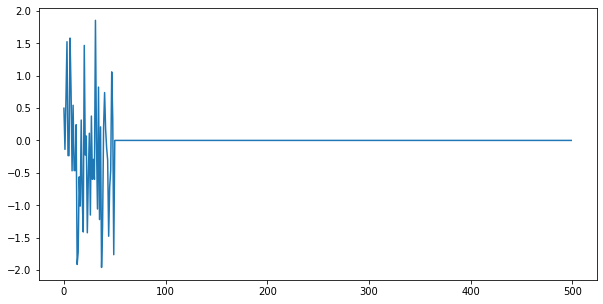

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n_train, n_test, n_features = 75, 150, 500

np.random.seed(42)
coef = np.random.randn(n_features)
coef[50:] = 0.0  # Solo los 50 primeros afectan el modelo
X = np.random.randn(n_train + n_test, n_features)
y = np.dot(X, coef)

# Divido en entrenamiento y test
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

# Miremos que efectivamente el efecto de coeficientes es de algunas
plt.figure(figsize=(10, 5))
plt.plot(coef)
plt.show()

Ahora haremos una regresión lineal usando todas las características (n_features):

R2 TRAIN = 1.0
R2 TEST = 0.07270775995151957


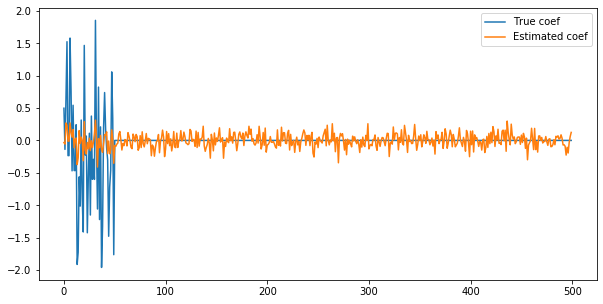

In [4]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
print("R2 TRAIN =", lr.score(X_train, y_train))
print("R2 TEST =", lr.score(X_test, y_test))
# Reviso los coeficientes del modelo
plt.figure(figsize=(10, 5))
plt.plot(coef, label="True coef")
plt.plot(lr.coef_, label="Estimated coef")
plt.legend()
plt.show()

Ahora que vimos que la regresión lineal usa todos las variables pero no consigue generalizar muy bien, sabemos que regularizar puede ser una opción.

Use scikit-learn para realizar regularización y comprobar (todos los puntos valen lo mismo para la nota):

*   RIDGE: revise cómo la regularización L2 afecta los coeficientes y la generalización,
*   LASSO: revise cómo la regularización L1 afecta los coeficientes y la generalización,
*   ELASTIC NET: revise cómo la combinación de L1 y L2 afecta los coeficientes y la generalización.

Debido a que estos modelos tienen hiper-parámetro de regularización, se espera que el análisis que se haga de los coeficientes sea después de hacer una búsqueda del mejor usando TEST como conjunto de validación. Espero gráficas de al menos los coeficientes usados (igual que la anterior) y de la búsqueda del hiperparámetro (score en train y test mientras cambia la regularización) y conclusiones escritas al respecto.

**TIP 1:** Normalmente el multiplicador de Lagrange (hiper-parámetro de regularización) se busca en escala logarítmica, por lo que np.logspace los podría ayudar en la tarea.

**TIP 2:** En [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), `alpha` no es el multiplicador de Lagrange directamente, sino la suma de ambos. Por esto recomiendo dejar fijo el `l1_ratio` y mover el `alpha` a conveniencia. El valor en que dijen `l1_ratio` debe depender de lo que encuentren más beneficioso en los modelos anteriores (L1 o L2).



### Ridge

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alphas = np.logspace(-10, 10, 1000)

In [30]:
_ridge_score_training = []
_ridge_score_test = []
_ridge_coefficients = []
_ridge_mse_y_pred_y_test = []

def fit_model_with_alpha(alpha_data_, x_train_, y_train_):
    ridge_ = Ridge(alpha = alpha_data_)
    ridge_.fit(x_train_, y_train_)
    _ridge_coefficients.append(ridge_.coef_)
    return ridge_
    
def evaluate_model(model_, x_train_, y_train_, x_test_, y_test_):
    y_pred = model_.predict(X_test)
    mse_ = mean_squared_error(y_pred,y_test)
    _ridge_mse_y_pred_y_test.append(mse_)    
    _ridge_score_training.append(model_.score(x_train_, y_train_))
    _ridge_score_test.append(model_.score(x_test_, y_test_))
    
for a in alphas:
    model_ = fit_model_with_alpha(a, X_train, y_train)
    evaluate_model(model_, X_train, y_train, X_test, y_test)
    

(1e-11, 100000000000.0, -0.4476835644587954, 0.3489124305838734)

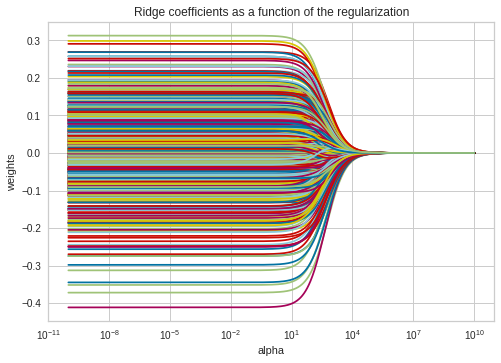

In [73]:
fig = plt.gca()
fig.plot(alphas, _ridge_coefficients)
fig.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

(1e-11, 100000000000.0, 39.567381278841864, 43.635437741111836)

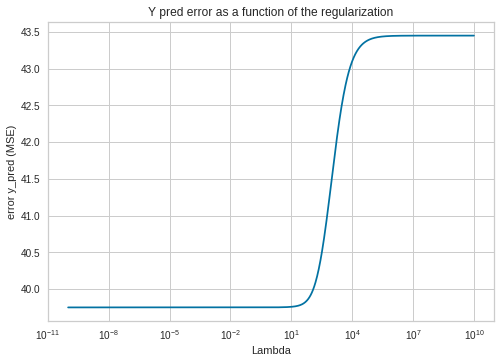

In [74]:
fig_2 = plt.gca()
fig_2.plot(alphas, _ridge_mse_y_pred_y_test)
fig_2.set_xscale('log')
plt.xlabel('Lambda')
plt.ylabel('error y_pred (MSE)')
plt.title('Y pred error as a function of the regularization')
plt.axis('tight')


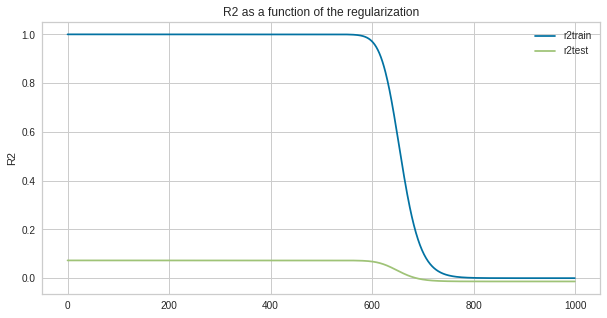

In [75]:
plt.figure(figsize=(10, 5))
plt.plot( _ridge_score_training, label = 'r2train')
plt.plot( _ridge_score_test, label = 'r2test')
#plt.set_xscale('log')
plt.ylabel('R2')
plt.title('R2 as a function of the regularization')
plt.legend()
plt.show()

In [66]:
def get_alpha():
    return alphas[np.argmin(_ridge_mse_y_pred_y_test)]

In [67]:
_best_model = Ridge(alpha=get_alpha())
_best_model.fit(X_train, y_train)
y_pred = _best_model.predict(X_test)

print("r2 Training =", _best_model.score(X_train, y_train))
print("r2 Test =", _best_model.score(X_test, y_test))



r2 Training = 1.0
r2 Test = 0.07275576588762889


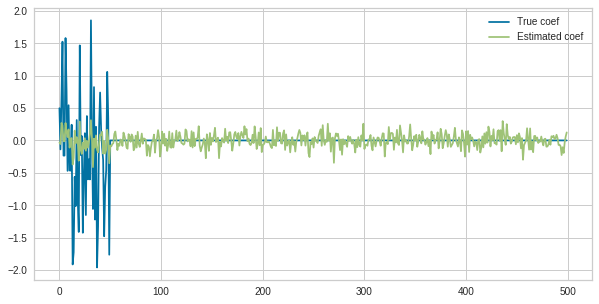

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(coef, label="True coef")
plt.plot(_best_model.coef_, label="Estimated coef")
plt.legend()
plt.show()

### LASSO

In [14]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

alphas_lasso = np.logspace(-200, 200, 1000)

In [15]:
_lasso_score_training = []
_lasso_score_test = []
_lasso_coefficients = []
_lasso_mse_y_pred_y_test = []

def fit_model_with_alpha(alpha_data_, x_train_, y_train_):
    lasso_ = Lasso(alpha = alpha_data_)
    lasso_.fit(x_train_, y_train_)
    _lasso_coefficients.append(lasso_.coef_)
    return lasso_
    
def evaluate_model(model_, x_train_, y_train_, x_test_, y_test_):
    y_pred = model_.predict(X_test)
    mse_ = mean_squared_error(y_pred,y_test)
    _lasso_mse_y_pred_y_test.append(mse_)    
    _lasso_score_training.append(model_.score(x_train_, y_train_))
    _lasso_score_test.append(model_.score(x_test_, y_test_))
    
for a in alphas_lasso:
    model_ = fit_model_with_alpha(a, X_train, y_train)
    evaluate_model(model_, X_train, y_train, X_test, y_test)
    

/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41018373929968105, tolerance: 0.32764537216683026
  positive)
/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7376832036618757, tolerance: 0.32764537216683026
  positive)
/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7154298342017217, tolerance: 0.32764537216683026
  positive)
/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want t

(1e-220, 1e+220, -2.2784070107624146, 2.474862337549394)

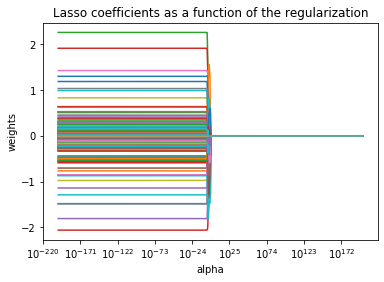

In [16]:
fig = plt.gca()
fig.plot(alphas_lasso, _lasso_coefficients)
fig.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')

(1e-220, 1e+220, 18.262647105236706, 44.64994929418247)

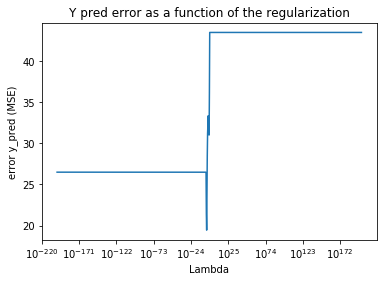

In [17]:
fig_2 = plt.gca()
fig_2.plot(alphas_lasso, _lasso_mse_y_pred_y_test)
fig_2.set_xscale('log')
plt.xlabel('Lambda')
plt.ylabel('error y_pred (MSE)')
plt.title('Y pred error as a function of the regularization')
plt.axis('tight')

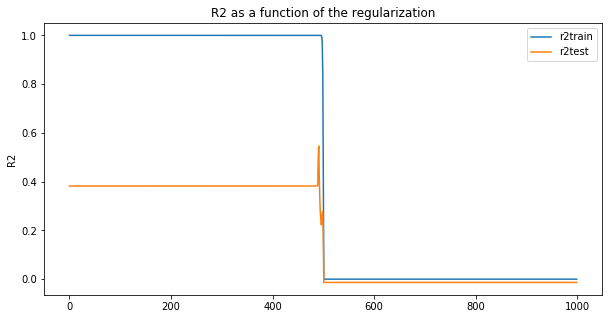

In [18]:
plt.figure(figsize=(10, 5))
plt.plot( _lasso_score_training, label = 'r2train')
plt.plot( _lasso_score_test, label = 'r2test')
#plt.set_xscale('log')
plt.ylabel('R2')
plt.title('R2 as a function of the regularization')
plt.legend()
plt.show()

In [19]:
def get_alpha_lasso():
    return alphas_lasso[np.argmax(_lasso_score_test)]

In [20]:
_best_model = Lasso(alpha=get_alpha_lasso())
_best_model.fit(X_train, y_train)
y_pred = _best_model.predict(X_test)

print("r2 Training =", _best_model.score(X_train, y_train))
print("r2 Test =", _best_model.score(X_test, y_test))


r2 Training = 0.9999999069402397
r2 Test = 0.5460364473239314


/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7376832036618757, tolerance: 0.32764537216683026
  positive)


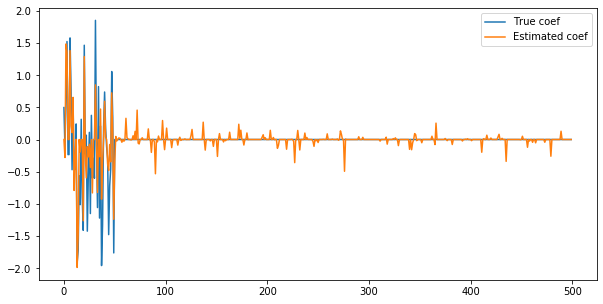

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(coef, label="True coef")
plt.plot(_best_model.coef_, label="Estimated coef")
plt.legend()
plt.show()

### Elastic NET

In [25]:
from sklearn.linear_model import ElasticNet


In [26]:
alphas_elastic_net = np.logspace(-200, 200,1000)

In [27]:
_enet_score_training = []
_enet_score_test = []
_enet_coefficients = []
_enet_mse_y_pred_y_test = []

alpha_lasso_ = get_alpha_lasso()

def fit_model_with_alpha(alpha_data_, x_train_, y_train_):
    enet_ = ElasticNet(l1_ratio=alpha_lasso_, alpha = alpha_data_)
    enet_.fit(x_train_, y_train_)
    _enet_coefficients.append(enet_.coef_)
    return enet_
    
def evaluate_model(model_, x_train_, y_train_, x_test_, y_test_):
    y_pred = model_.predict(X_test)
    mse_ = mean_squared_error(y_pred,y_test)
    _enet_mse_y_pred_y_test.append(mse_)    
    _enet_score_training.append(model_.score(x_train_, y_train_))
    _enet_score_test.append(model_.score(x_test_, y_test_))
    
for a in alphas_elastic_net:
    model_ = fit_model_with_alpha(a, X_train, y_train)
    evaluate_model(model_, X_train, y_train, X_test, y_test)    

/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34839455013722903, tolerance: 0.32764537216683026
  positive)
/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5158592398491335, tolerance: 0.32764537216683026
  positive)
/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8277478877080034, tolerance: 0.32764537216683026
  positive)
/home/juanespe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want t

(1e-220, 1e+220, -2.278407010762415, 2.474862337549394)

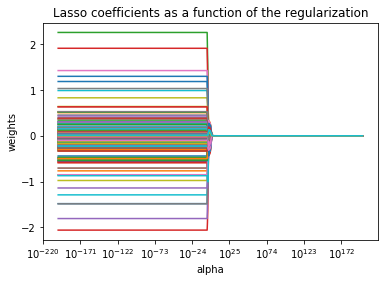

In [28]:
fig = plt.gca()
fig.plot(alphas_elastic_net, _enet_coefficients)
fig.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')

(1e-220, 1e+220, 21.404210567706414, 46.19009742933064)

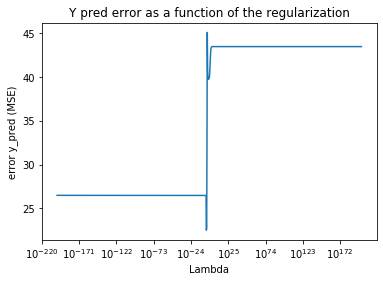

In [29]:
fig_2 = plt.gca()
fig_2.plot(alphas_elastic_net, _enet_mse_y_pred_y_test)
fig_2.set_xscale('log')
plt.xlabel('Lambda')
plt.ylabel('error y_pred (MSE)')
plt.title('Y pred error as a function of the regularization')
plt.axis('tight')

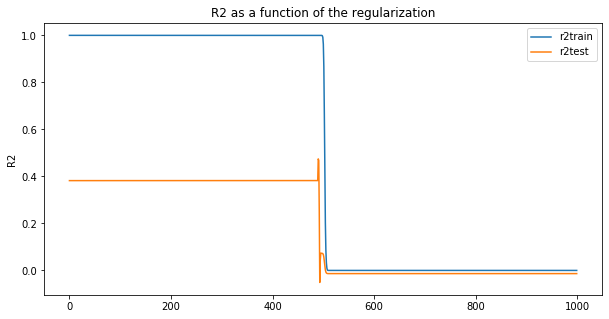

In [30]:
plt.figure(figsize=(10, 5))
plt.plot( _enet_score_training, label = 'r2train')
plt.plot( _enet_score_test, label = 'r2test')
#plt.set_xscale('log')
plt.ylabel('R2')
plt.title('R2 as a function of the regularization')
plt.legend()
plt.show()

In [31]:
def get_alpha_enet():
    return alphas_elastic_net[np.argmax(_enet_score_test)]

In [32]:
get_alpha_enet()

0.00015710723892475067

In [33]:
np.amax(_enet_score_test)

0.474455645318859

In [34]:
_best_model = ElasticNet(alpha=get_alpha_enet(),l1_ratio=alpha_lasso_)
_best_model.fit(X_train, y_train)
y_pred = _best_model.predict(X_test)

print("r2 Training =", _best_model.score(X_train, y_train))
print("r2 Test =", _best_model.score(X_test, y_test))


r2 Training = 0.9999999999349821
r2 Test = 0.474455645318859


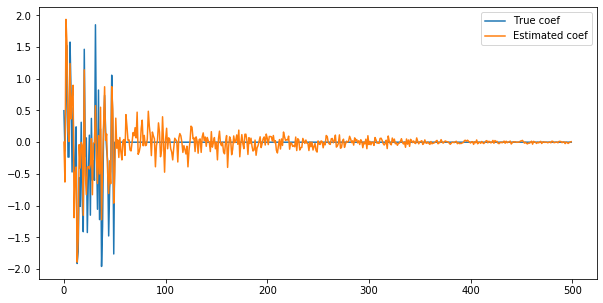

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(coef, label="True coef")
plt.plot(_best_model.coef_, label="Estimated coef")
plt.legend()
plt.show()

### Conclusiones:

Se ha realizado el ejercicio de regularizar los coeficientes, con el fin de tener un menor error de generalización. 
El procedimiento fue el siguiente para los tres algoritmos:
    
    1. Se realiza con el mismo conjunt de pruebas diferentes modelos, variando el hiperparametro alfa.
    2. Se realizan las predicciones con los diferentes modelos sobre los datos de prueba y se selecciona el modelo donde
    el hiperparametro permite genera el modelo con mejor r2 score sobre los datos de prueba.
    3. Se realizan las gráficas correspondientes de los pesos de los coeficientes reales vs los coeficientes predecidos.
    4. Se realizan las graficas del error de entrenamiento y pruebas a medida que se varía los hiperparametros.
    
Luego de realizar los anteriores pasos se 
